In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import bisect

# функция для получения шага сетки между двумя 
def h(x, i):
    return x[i] - x[i-1]

# функция для решения системы стрехдиагональной матрицей
def tdma(a, b, c, d, n):
    p = [0] * (n-1)
    q = [0] * n

    p[0] = -c[0] / b[0]
    q[0] = d[0] / b[0]

    for i in range(1, n):
        denum = a[i-1] * p[i-1] + b[i]

        if(i < n - 1):
            p[i] = -c[i] / denum
        q[i] = (d[i] - a[i-1] * q[i-1]) / denum

    res = [0] * n

    res[n-1] = q[n-1]

    for i in range(n-2, -1, -1):
        x = p[i] * res[i+1] + q[i]
        res[i] = x

    return res

# кубический сплайн
class CubicSpline:
    class Segment:
        def __init__(self, a, b, c, d):
            self.a = a
            self.b = b
            self.c = c
            self.d = d

    def __init__(self, x, f):
        n = len(x)
        assert n == len(f)

        n -= 2
       
        a = [0] * (n-1)
        b = [0] * n
        c = [0] * (n-1)
        d = [0] * n

        b[0] = 2.0 * (h(x, 1) + h(x, 2))
        c[0] = h(x, 2)

        for i in range(1, n-1):
            a[i-1] = h(x, i+1)
            b[i] = 2.0 * (h(x, i+1) + h(x, i+2))
            c[i] = h(x, i+2)

        a[n-2] = h(x, n-2)
        b[n-1] = 2.0 * (h(x, n-2) + h(x, n-1))

        for i in range(n):
            d[i] = 3.0 * ((f[i+2] - f[i+1])/h(x, i+2) - (f[i+1] - f[i]) / h(x, i+1))
        
        cc = tdma(a, b, c, d, n)
        cc = [0.0] + cc

        n += 2

        self.__seg = [self.Segment(0,0,0,0) for i in range(n-1)]
        for i in range(n-2):
            self.__seg[i].a = f[i]
            self.__seg[i].b = (f[i+1] - f[i]) / h(x, i+1) - h(x, i+1)*(cc[i+1] + 2.0 * cc[i]) / 3.0
            self.__seg[i].c = cc[i]
            self.__seg[i].d = (cc[i+1] - cc[i]) / (3.0 * h(x, i+1))
        
        self.__seg[n-2].a = f[n-2]
        self.__seg[n-2].b = (f[n-1] - f[n-2]) / h(x, n-1) - 2.0 * h(x, n-1) * cc[n-2] / 3.0
        self.__seg[n-2].c = cc[n-2]
        self.__seg[n-2].d = -cc[n-2] / (3.0 * h(x, n-1))

        self.__x = x

    def bisect(self, x):
        if x == self.__x[0]:
            return 0
        return bisect.bisect_left(self.__x, x) -1

    def __call__(self, x):

        if x < self.__x[0]:
            x = self.__x[0]
        elif x > self.__x[-1]:
            x = self.__x[-1]

        a = self.bisect(x)
        s = self.__seg[a]

        h = (x - self.__x[a])


        return s.a + s.b * h + s.c * h*h + s.d * h*h*h

max_error=17.85620443643944 at point x=5.627462746274627


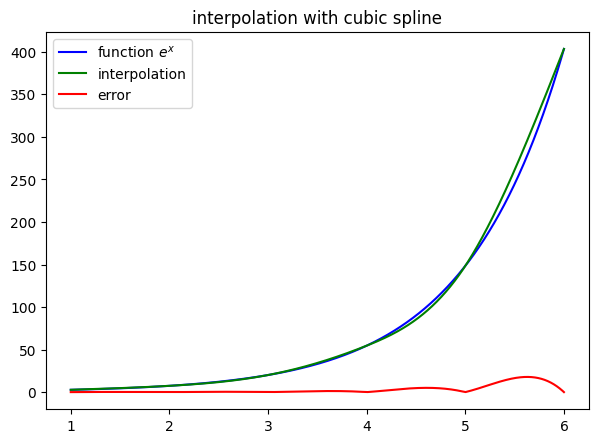

In [3]:
interval = (1, 6) # интервал интерполяции
function = np.exp # исходная функция (вариант 3)

x = np.arange(interval[0], interval[1] + 1)
y = function(x)

spline = CubicSpline(x, y)

# сетка для проверки погрешности и графика
points_x = np.linspace(interval[0], interval[1], 10000)

# значения исходной функции в узлах сетки
points_y_reference = function(points_x)

# значения интерполяционного многочлена в узлах сетки
points_y_interpolation = np.array([spline(p) for p in points_x])

# ошибка интерполяции
error = np.abs(points_y_reference - points_y_interpolation)

fig=plt.figure(figsize=(7,5), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(points_x, points_y_reference, 'b', label='function $e^{x}$')
plt.plot(points_x, points_y_interpolation, 'g', label='interpolation')
plt.plot(points_x, error, 'r', label='error')
plt.title(f'interpolation with cubic spline')
plt.legend()

# вычисление максимальной ошибки и точки, в которой она происходит
max_error = np.max(error)
max_error_point = points_x[np.argmax(error)]

print(f'max_error={max_error} at point x={max_error_point}')